<a href="https://colab.research.google.com/github/FrancescoTorella/progettoLabAI/blob/main/from_geojson_to_mask_jpg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install geojson shapely numpy pillow


In [16]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 47.3 MB/s eta 0:00:00


In [17]:
import geojson
from shapely.geometry import shape
import numpy as np
from PIL import Image, ImageDraw
import rasterio
import matplotlib.pyplot as plt

In [27]:
import os
import random

In [4]:
# Monta Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
def geojson_to_mask(geojson_file, tiff_file, img_width, img_height):
    # Leggi la trasformazione affine dal file TIFF originale
    with rasterio.open(tiff_file) as src:
        transform = src.transform
        original_img = src.read([1, 2, 3])  # Supponiamo che l'immagine sia in formato RGB nei primi tre canali

    # Converti l'immagine originale in formato RGB
    original_img = np.dstack([original_img[0], original_img[1], original_img[2]])

    # Leggi il file GeoJSON
    with open(geojson_file, 'r') as f:
        geojson_data = geojson.load(f)

    # Crea un'immagine binaria vuota
    mask = Image.new('L', (img_width, img_height), 0)
    draw = ImageDraw.Draw(mask)

    # Funzione per trasformare le coordinate geospaziali in coordinate pixel
    def transform_coords(coords, transform):
        transformed_coords = []
        for coord in coords:
            x, y = coord[:2]  # Estrarre solo le prime due componenti
            px, py = ~transform * (x, y)
            transformed_coords.append((int(px), int(py)))
        return transformed_coords

    # Disegna i poligoni sulla maschera
    for feature in geojson_data['features']:
        geom = shape(feature['geometry'])
        if geom.geom_type == 'Polygon':
            exterior_coords = transform_coords(geom.exterior.coords, transform)
            draw.polygon(exterior_coords, outline=1, fill=255)
        elif geom.geom_type == 'MultiPolygon':
            for poly in geom.geoms:
                exterior_coords = transform_coords(poly.exterior.coords, transform)
                draw.polygon(exterior_coords, outline=1, fill=255)

    # Converti l'immagine PIL in un array NumPy
    mask = np.array(mask)

    return original_img, mask


   roof_075mean  roof_075median  roof_075stdev  Building_ID     origarea  \
0         12.02           12.02            0.0        48360   805.231283   
1          3.41            3.41            0.0        25004     6.447777   
2         16.02           16.02            0.0        23045  2244.566523   
3          1.00            1.00            0.0        23159    12.832431   
4         -1.35           -1.35            0.0        23179    11.698850   

   origlen  partialDec  truncated  \
0        0    0.404032          1   
1        0    0.866348          1   
2        0    1.000000          0   
3        0    0.829287          1   
4        0    1.000000          0   

                                            geometry  
0  MULTIPOLYGON Z (((596311.818 5749386.654 0.000...  
1  POLYGON Z ((596311.818 5749444.708 0.000, 5963...  
2  POLYGON Z ((596179.390 5749206.121 0.000, 5961...  
3  POLYGON Z ((595861.824 5749231.122 0.000, 5958...  
4  POLYGON Z ((595869.155 5749231.218 0.000, 

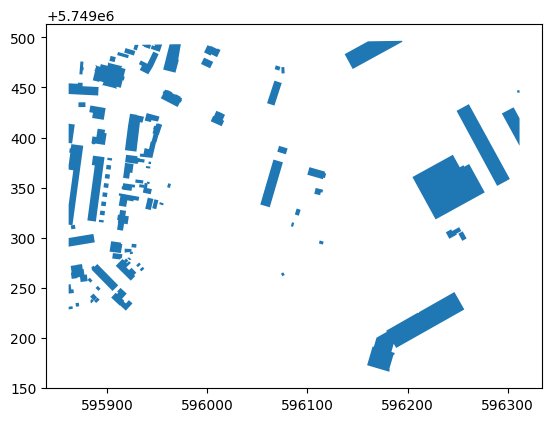

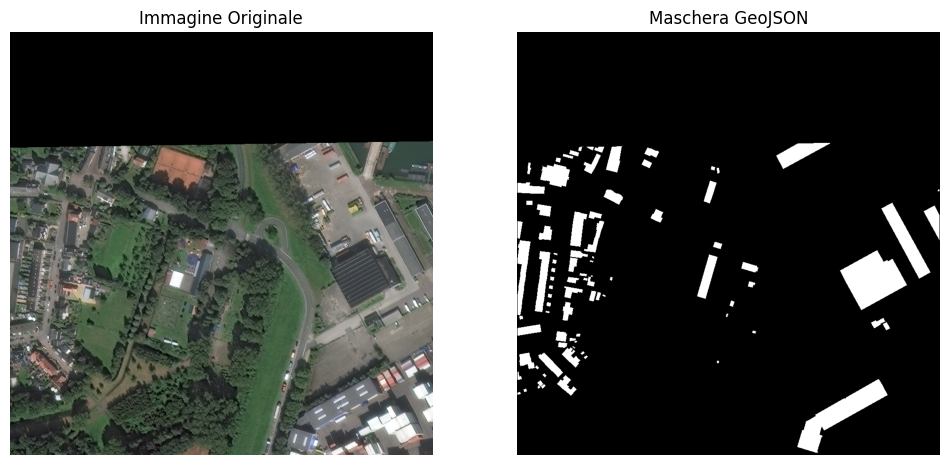

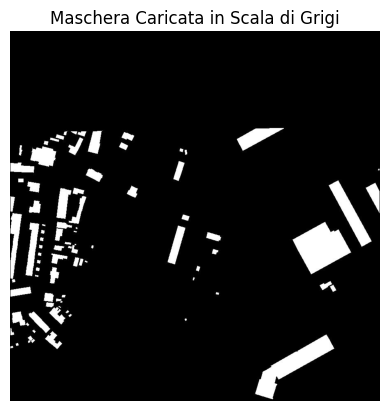

In [25]:
geojson_file = '/content/drive/My Drive/progettoLabAi3/train/geojson_buildings/SN6_Train_AOI_11_Rotterdam_Buildings_20190823160819_20190823161113_tile_11043.geojson'

# Leggi il file GeoJSON
gdf = gpd.read_file(geojson_file)

# Visualizza il contenuto del GeoDataFrame
print(gdf.head())

# Plotta il GeoDataFrame
gdf.plot()
plt.show()

tiff_file = '/content/drive/My Drive/progettoLabAi3/train/PS-RGB/SN6_Train_AOI_11_Rotterdam_PS-RGB_20190823160819_20190823161113_tile_11043.tif'
img_width, img_height = 900, 900  # Assicurati che queste dimensioni corrispondano a quelle delle tue immagini
original_img, mask = geojson_to_mask(geojson_file, tiff_file, img_width, img_height)

# Salva la maschera come immagine
mask_path = '/content/drive/My Drive/progettoLabAi3/train/mask/SN6_Train_AOI_11_Rotterdam_Buildings_20190823160819_20190823161113_tile_11043_mask.jpg'
mask_img = Image.fromarray(mask)
mask_img.save(mask_path)

# Visualizza l'immagine originale e la maschera affiancate
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(original_img)
axes[0].set_title('Immagine Originale')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Maschera GeoJSON')
axes[1].axis('off')

plt.show()

# Carica la maschera salvata e convertila in scala di grigi
loaded_mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

# Visualizza la maschera caricata per verificare
plt.imshow(loaded_mask, cmap='gray')
plt.title('Maschera Caricata in Scala di Grigi')
plt.axis('off')
plt.show()


## Conversione di tutti i file

Dopo aver convertito un singolo file vorrei assicurarmi che tutti i file vengano convertiti

In [ ]:
# Percorsi delle directory
tiff_dir = '/content/drive/My Drive/progettoLabAi3/train/PS-RGB'
geojson_dir = '/content/drive/My Drive/progettoLabAi3/train/geojson_buildings'
mask_dir = '/content/drive/My Drive/progettoLabAi3/train/mask'

# Assicurati che la directory delle maschere esista
os.makedirs(mask_dir, exist_ok=True)

# Ottieni tutti i file TIFF
tiff_files = [f for f in os.listdir(tiff_dir) if f.endswith('.tif')]


# Lista per memorizzare i percorsi delle immagini trasformate per visualizzazione casuale
transformed_images = []

for tiff_file in tiff_files:
    # Costruisci i percorsi dei file
    tiff_path = os.path.join(tiff_dir, tiff_file)
    base_name = os.path.splitext(tiff_file)[0]
    geojson_file = f'{base_name.replace("PS-RGB", "Buildings")}.geojson'
    geojson_path = os.path.join(geojson_dir, geojson_file)
    mask_file = f'{base_name.replace("PS-RGB", "Buildings")}_mask.jpg'
    mask_path = os.path.join(mask_dir, mask_file)

    # Verifica se i file esistono
    if not os.path.exists(geojson_path):
        print(f'File GeoJSON non trovato: {geojson_path}')
        continue

    # Esegui la conversione
    img_width, img_height = 900, 900  # Assicurati che queste dimensioni corrispondano a quelle delle tue immagini
    original_img, mask = geojson_to_mask(geojson_path, tiff_path, img_width, img_height)

    # Salva la maschera come immagine
    mask_img = Image.fromarray(mask)
    mask_img.save(mask_path)
    print(f'Salvata maschera: {mask_path}')

    # Aggiungi il percorso delle immagini trasformate per visualizzazione casuale
    transformed_images.append((original_img, mask))

# Visualizza alcune immagini e maschere scelte a caso
num_samples_to_display = 5
samples = random.sample(transformed_images, num_samples_to_display)

for i, (original_img, mask) in enumerate(samples):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img)
    axes[0].set_title(f'Immagine Originale {i+1}')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f'Maschera GeoJSON {i+1}')
    axes[1].axis('off')

    plt.show()

Salvata maschera: /content/drive/My Drive/progettoLabAi3/train/mask/SN6_Train_AOI_11_Rotterdam_Buildings_20190823081159_20190823081456_tile_5211_mask.jpg
Salvata maschera: /content/drive/My Drive/progettoLabAi3/train/mask/SN6_Train_AOI_11_Rotterdam_Buildings_20190823093548_20190823093858_tile_5489_mask.jpg
Salvata maschera: /content/drive/My Drive/progettoLabAi3/train/mask/SN6_Train_AOI_11_Rotterdam_Buildings_20190804135937_20190804140208_tile_6557_mask.jpg
Salvata maschera: /content/drive/My Drive/progettoLabAi3/train/mask/SN6_Train_AOI_11_Rotterdam_Buildings_20190823132244_20190823132535_tile_2787_mask.jpg
Salvata maschera: /content/drive/My Drive/progettoLabAi3/train/mask/SN6_Train_AOI_11_Rotterdam_Buildings_20190822144046_20190822144338_tile_1493_mask.jpg
Salvata maschera: /content/drive/My Drive/progettoLabAi3/train/mask/SN6_Train_AOI_11_Rotterdam_Buildings_20190822144046_20190822144338_tile_1478_mask.jpg
Salvata maschera: /content/drive/My Drive/progettoLabAi3/train/mask/SN6_Trai